# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


### Load the data into Pandas dataframe

In [2]:
df = pd.read_csv('./train_Data.csv',)
df.head()

,Label,Tweets,Unnamed: 0
0,0.0,@hidenhand1 @RichieAllenShow The truth the wh...,NaN
1,0.0,#Trudeau #ISIS How is this possible? https://...,NaN
2,0.0,おはよう、おやすみ、こんにちは、こんばんは、おおはよう、こんにちは、こんばんは、おやすみ、寝...,NaN
3,0.0,Again an excellent report by @Tantalite on the...,NaN
4,0.0,.@CJTFOIR denies reports the coalition/coaliti...,NaN


Drop the columns that are not required for the neural network.

In [3]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27773 entries, 0 to 27772
Data columns (total 2 columns):
Label     26006 non-null float64
Tweets    27773 non-null object
dtypes: float64(1), object(1)
memory usage: 434.0+ KB


In [4]:
values={'Label':0}
df=df.fillna(value=values)
df['Label'].unique()

array([0., 1.])

Understand the distribution better.

Text(0.5,1,'Number of 1 and 0 messages')

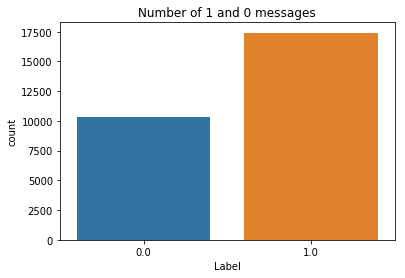

In [5]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of 1 and 0 messages')

* Create input and output vectors.
* Process the labels.

In [6]:
X = df.Tweets
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.9)

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [8]:
max_words = 1000
max_len = max(df['Tweets'].apply(len))

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### RNN
Define the RNN structure.

In [9]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [10]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 41895)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 41895, 50)         50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)  

Fit on the training data.

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 2221 samples, validate on 556 samples
Epoch 1/10


The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))